# Bayes Filter Walkthrough

One of the issues that can arise and confuse students is how to break down the somewhat verbose language used in the probabilistic notation for robotics and how to model it in code. In this example we'll walk through the simple one-dimensional case shown in the lecture slide of a robot moving down a hallway.

In pseudocode, a Bayes' Filter can be accurately summarized by two functions: `predict` (which operates with the transition probabiilty ($p(x_t | u_t, x_{t-1})$ ) and `update` (which operates with the measurement probability ($p(z_t | x_t)$). This breakdown will continue to occur when we explore other implementations and solutions to the Bayes Filter later in the course. Uniquely to Bayes' Filter however, the filter maintains only a probability distribution over the state space. This ends up being problematic for any serious use case, but examining it in a simplified manner we can get accustomed to the the probability notation and build a good probabilitic foundation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, uniform

So we'll start off with our assumptions. We'll assume the hallway is ten meters long and that our belief is normally distributed across the hallway and that we believe the robot is located at about two meters.

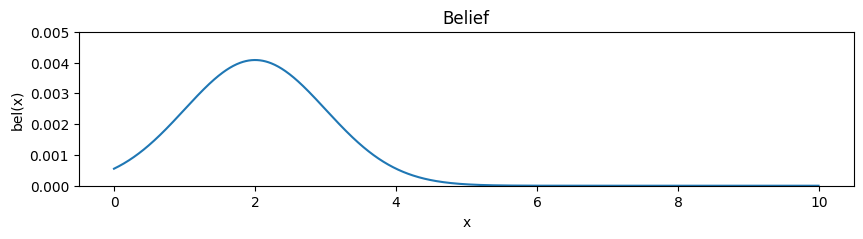

In [2]:
x = np.arange(0, 10, 0.01).reshape(-1, 1)
#bel = np.zeros_like(x) + 1/10
bel = norm(2, 1).pdf(x)
bel /= bel.sum()
fig_size = (10, 2)

fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x, bel, label='bel(x)')
ax.set_ylim(0, 0.005)
ax.set_xlabel('x')
ax.set_ylabel('bel(x)')
ax.set_title('Belief')
plt.show()

Next let's examine the transition probability for the `predict` function. Understand that this is *just* a probability function. It can be any sort of continuous or piecewise function so long as it obeys the law of total probability and sums to one. For demonstration, we'll assume that the previous state $x_{t-1}$ has no effect on our transition. 

Part of what makes Bayes' Filter intractable for anything more than trivial problems is the need to get the transition probability of *every* state with respect to *every other* state ($p(x_t | x_{t-1}, u_t)$). The trivial answer would be to iterate through each discrete state, but even in this simple example that would take too long. As a Python rule of thumb: avoid loops in Python, particularly for large repeated calculations. Taking a step back, with some inspection, you can see that the transition probability function is really just a matrix of scalar values. $p_{ij}$ therefore is simply the specific probability scalar of transitioning from $x_{i,t}$ to $x_{j, t} \rightarrow p(x_{i,t} | x_{j,t-1}, u_t)$. Reframing the operation as such, we can see that the prediction function can be accomplished with some simple linear algebra. Better yet, NumPy's linear algebra capabilities are written in highly-optimized C code and run extremely quickly. This is referred to as "vectorizing" where a loop or repeated calculation is executed using linear algebra. We will be using this technique a lot in this course.

We'll define the transition probability a couple of different ways below for demonstration. However, at it's base, the likelihood is based on the distance traveled and thus the difference between the state at each timestep given the control. To get the elementwise value of a mathematical operation for a vector, first ensure it is shaped as (n, 1) or (1, n) and then execute the operation with the transpose (ex: `x + x.T`). Note that NumPy treats one dimensional arrays (n, ) and two dimensional arrays with a trivial second dimension (n,1) slighly differently. This opperation only works with the second kind so that NumPy can figure out how to broadcast the resulting matrix.

It's still not as bad as Matlab where you can't even have one-dimensional arrays.

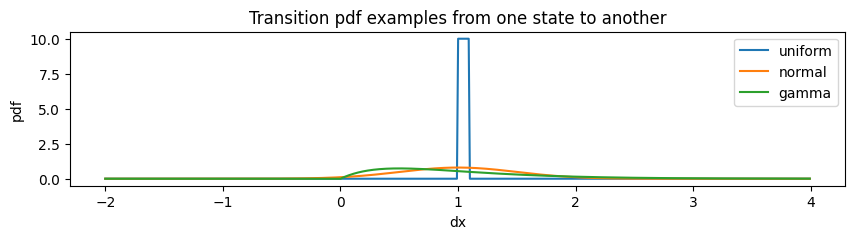

In [3]:
# Transition probability
dx = np.arange(-2, 4, 0.01) # All possible transition distances
u = 1                       # Our commanded velocity / change in distance
s = 0.5                     # Robot's accuracy in measuring velocity
p_x_u_norm = norm.pdf(dx, u, s)
p_x_u_uniform = uniform.pdf(dx, loc=1, scale=0.1)
p_x_u_gamma = gamma(2, scale=s).pdf(dx)

fig, ax = plt.subplots(figsize=fig_size)
plt.plot(dx, p_x_u_uniform, label='uniform')
plt.plot(dx, p_x_u_norm, label='normal')
plt.plot(dx, p_x_u_gamma, label='gamma')
#ax.set_ylim(0, 1.1)
ax.set_xlabel('dx')
ax.set_ylabel('pdf')
ax.legend()
ax.set_title('Transition pdf examples from one state to another')

plt.show()

Uniform and normal distributions are fairly straightforward ways to interpret as representations of a sensor input accurate to $\pm 1$ m/s. The gamma distribution is merely there for addtional demonstration.

We'll assume a normal probabilty transition model, it'll come in handy later on. Let's apply the transition for a control of 1 m/s.

In [4]:
dx = x - x.T
# Define the transition probability across all dx, we *expect* a dx = u = 1
p_transition = norm.pdf(dx, u, s)
# normalize the transition probability for each row to go from pdf to probability
p_transition /= p_transition.sum(axis=1, keepdims=True)

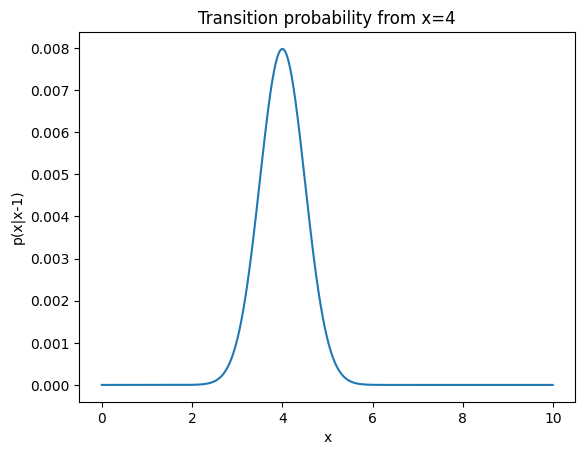

In [5]:
plt.plot(x, p_transition[500, :])
plt.xlabel('x')
plt.ylabel('p(x|x-1)')
plt.title("Transition probability from x=4")
plt.show()

In [6]:
# Execute the prediction step using vectorized operations
bel = p_transition @ bel

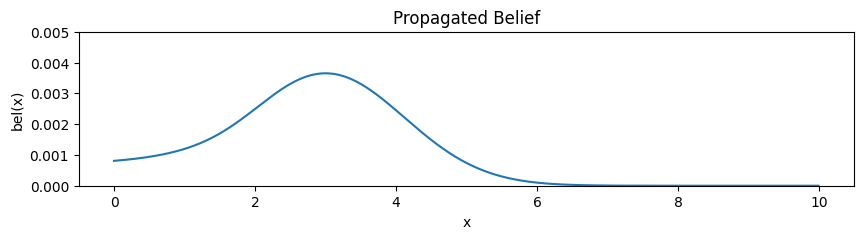

In [7]:
fig, ax = plt.subplots(figsize=fig_size)
plt.plot(x, bel, label='p(x|u) = norm(x|u,s)')
ax.set_ylim(0, 0.005)
ax.set_xlabel('x')
ax.set_ylabel('bel(x)')
ax.set_title('Propagated Belief')
plt.show()

We can now see that our belief distribution has shifted to the right by about one meter. However, the distribution has gotten 
Now let's take a measurement. The doors in the hallway are placed at three meters, four meters, and seven meters from the start and can be detected within 0.25 meters.

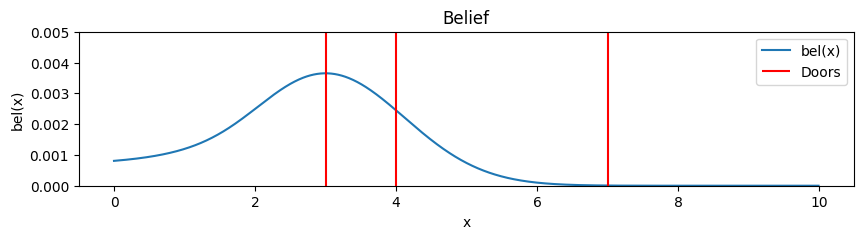

In [8]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x, bel, label='bel(x)')
ax.set_ylim(0, 0.005)
ax.set_xlabel('x')
ax.set_ylabel('bel(x)')
ax.set_title('Belief')
ax.vlines([3, 4, 7], 0, 0.5, label='Doors', color='r')
ax.legend()
plt.show()

Similarly we will assume a normal distribution centered on each door for our update measurement probability. The central limit theorum and law of large numbers tell us that modeling things as a normal or Gaussian distribution is usually a safe bet. Our measurement camera is realtively rudimentary it simply reports if it has seen a door.

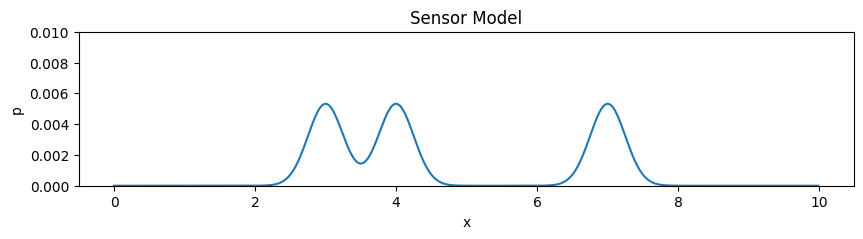

In [9]:
p_z_3 = norm(3, 0.25).pdf(x)
p_z_4 = norm(4, 0.25).pdf(x)
p_z_7 = norm(7, 0.25).pdf(x)
p_z = p_z_3 + p_z_4 + p_z_7
p_z = p_z / p_z.sum()

fig, ax = plt.subplots(figsize=fig_size)
plt.plot(x, p_z, label='p(z|x)')
ax.set_ylim(0, 0.01)
ax.set_xlabel('x')
ax.set_ylabel('p')
ax.set_title('Sensor Model')
plt.show()

Applying this to the predicted belief:

In [10]:
# Apply measurement update
bel = p_z * bel
bel /= bel.sum()

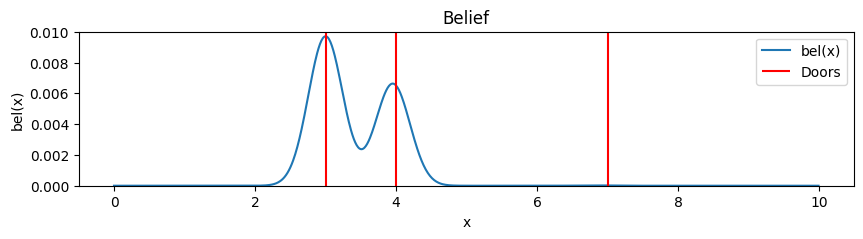

In [11]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x, bel, label='bel(x)')
ax.set_ylim(0, 0.01)
ax.set_xlabel('x')
ax.set_ylabel('bel(x)')
ax.set_title('Belief')
ax.vlines([3, 4, 7], 0, 0.5, label='Doors', color='r')
ax.legend()
plt.show()

We can now see a few likely, albeit low probability, locations where we think the robot is. Let's again move.

In [12]:
bel = p_transition @ bel

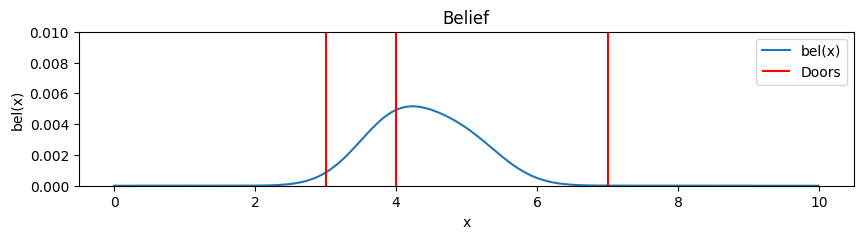

In [13]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x, bel, label='bel(x)')
ax.set_ylim(0, 0.01)
ax.set_xlabel('x')
ax.set_ylabel('bel(x)')
ax.set_title('Belief')
ax.vlines([3, 4, 7], 0, 0.5, label='Doors', color='r')
ax.legend()
plt.show()

Again, we see that the distribution has shifted to the right again and flattened out. Prediction (or propagation) increases uncertainty in the system while measurement decreases it. After prediction, the robot then reports that it has seen a door.

In [14]:
# Apply measurement update
bel = p_z * bel
bel /= bel.sum()

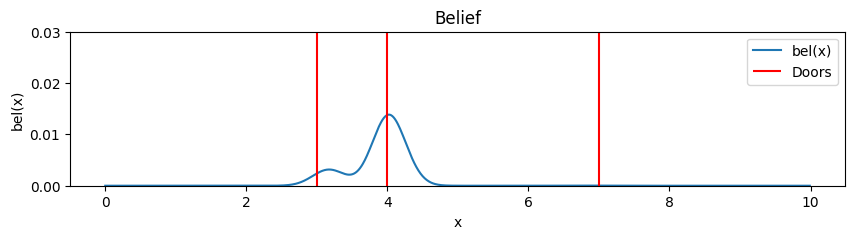

In [15]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x, bel, label='bel(x)')
ax.set_ylim(0, 0.03)
ax.set_xlabel('x')
ax.set_ylabel('bel(x)')
ax.set_title('Belief')
ax.vlines([3, 4, 7], 0, 0.5, label='Doors', color='r')
ax.legend()
plt.show()

At this point we can now pretty confidently say we are at approximately four meters from the start of the hallway. Let's move again. The camera again (incorrectly) reports that it saw a door.

In [16]:
# Apply the prediction
bel = p_transition @ bel
# Apply measurement update
bel = p_z * bel
bel /= bel.sum()

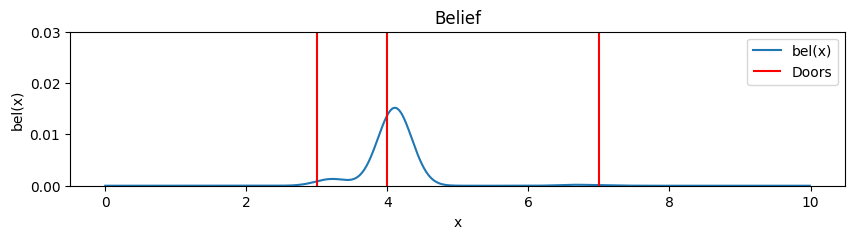

In [17]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x, bel, label='bel(x)')
ax.set_ylim(0, 0.03)
ax.set_xlabel('x')
ax.set_ylabel('bel(x)')
ax.set_title('Belief')
ax.vlines([3, 4, 7], 0, 0.5, label='Doors', color='r')
ax.legend()
plt.show()

From this we can see now that belief thinks that we're closer to four meters then where we should be (five meters). The measurement updates are not corresponding to the filter's belief as to where it should be. Let's move again. This time the robot does not report a door.

In [18]:
# Apply the prediction
bel = p_transition @ bel

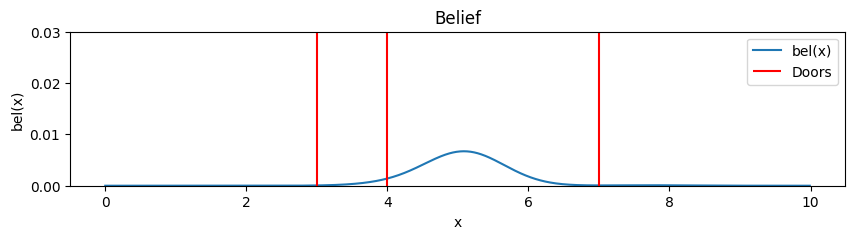

In [19]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x, bel, label='bel(x)')
ax.set_ylim(0, 0.03)
ax.set_xlabel('x')
ax.set_ylabel('bel(x)')
ax.set_title('Belief')
ax.vlines([3, 4, 7], 0, 0.5, label='Doors', color='r')
ax.legend()
plt.show()

Now we're closer to where we think we should be. Let's move one final time. This time we do get a door measurement.

In [20]:
# Apply the prediction
bel = p_transition @ bel
# Apply measurement update
bel = p_z * bel
bel /= bel.sum()

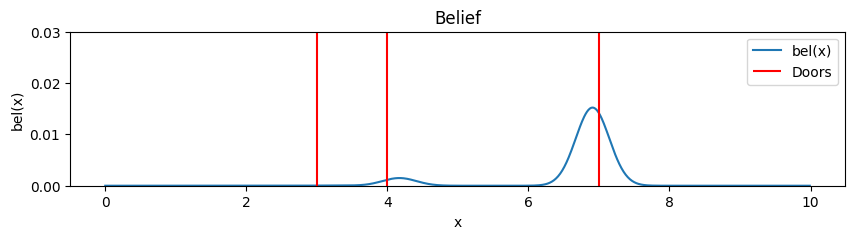

In [21]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x, bel, label='bel(x)')
ax.set_ylim(0, 0.03)
ax.set_xlabel('x')
ax.set_ylabel('bel(x)')
ax.set_title('Belief')
ax.vlines([3, 4, 7], 0, 0.5, label='Doors', color='r')
ax.legend()
plt.show()